In [1]:
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

from basin_volume import *
from basin_volume.math import *

In [2]:
def make_kl_fn(probs_p, apply_fn, x, l2_reg):
    def kl_fn(a, b):
        params_q = a + b
        logits_q = apply_fn(params_q, x)
        logprobs_q = jax.nn.log_softmax(logits_q)
        kl_term = optax.kl_divergence(logprobs_q, probs_p).mean()
        l2_term = 1/2 * l2_reg * jnp.sum(b**2)
        return kl_term + l2_term
    return kl_fn

def make_kl_fn_params(params_p, apply_fn, x, *, l2_reg):
    logits_p = apply_fn(params_p, x)
    probs_p = jax.nn.softmax(logits_p)
    return make_kl_fn(probs_p, apply_fn, x, l2_reg=l2_reg)

## Model-specific setup

In [3]:
# we can set mesa_constrain=True and norm_scale=(float) to clamp the norm of the parameters
# instead, we'll add an L2 penalty to the loss function here:
cfg = MLPTrainConfig(train_size=1024, 
                     opt="adam", 
                     lr=.05,
                     l2_reg=5e-4,
                     d_inner=64*8,
                     num_layers=5,
                    )

In [4]:
# Train the model
# This needs a refactor -- all the messiness is hiding in training.py
# You don't need to worry about it to use this package with other models

final_params, state, apply_fn, X_train = train_mlp(cfg)

In [5]:
print(final_params.raveled.shape)

(1089034,)


In [6]:
kl_fn = make_kl_fn_params(final_params.raveled, apply_fn, X_train, l2_reg=0.)

In [7]:
# H = jax.hessian(kl_fn, argnums=0)(final_params.raveled, 0)

In [7]:
adam_state, _, schedule_state = state.opt_state
mu, nu = adam_state.mu['p'], adam_state.nu['p']

# standard deviation of the Gaussian we'll use to weight our estimates
sigma_epoch = 1/jnp.sqrt(cfg.l2_reg * cfg.train_size)

In [15]:
print(sigma_epoch)

1.3975424


In [14]:
print(jnp.sqrt(jnp.mean(final_params.raveled**2, axis=0)))


0.23462357


## Volume estimation

In [8]:
CUTOFF = 1e-2

RESULTS = {} # estimates, props, mults, deltas, logabsint

In [138]:
RESULTS['naive'] = get_estimates_vectorized_gauss(1000, 
                                                  sigma=sigma_epoch,
                                                  fn=kl_fn, 
                                                  params=final_params.raveled, 
                                                  cutoff=CUTOFF,
                                                  tol=0.1,
                                                  debug=False,
                                                 )


In [52]:
P_adam_mu = diag_preconditioner(mu, eps=4e-3, exponent=0.3)
RESULTS['adam_mu'] = get_estimates_vectorized_gauss(100, 
                                                    sigma=sigma_epoch,
                                                    preconditioner=P_adam_mu, 
                                                    fn=kl_fn, 
                                                    params=final_params.raveled, 
                                                    cutoff=CUTOFF,
                                                    tol=10,
                                                    )


2024-12-13 02:42:03.742735: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3020] Can't reduce memory use below -4.07TiB (-4470416519688 bytes) by rematerialization; only reduced to 4.31TiB (4743980212624 bytes), down from 4.31TiB (4743980212624 bytes) originally
2024-12-13 02:42:03.744528: E external/xla/xla/status_macros.cc:56] INTERNAL: RET_CHECK failure (external/xla/xla/service/gpu/fusions/fusion_emitter.cc:95) device_info.block_dim_limit().x == 0 || launch_dims.block_counts().x < device_info.block_dim_limit().x Kernel 'loop_select_fusion' launch needs more blocks (2316396589) than allowed by hardware (2147483647).
*** Begin stack trace ***
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	PyObject_Vectorcall
	_PyEval_EvalFrameDefault
	_PyFunction_Vectorcall
	_PyEval_EvalFrameDefault
	_PyFunction_Vectorcall
	PyObject_Vectorcall
	
	
	
	
	
	_PyObject_FastCallDictTstate
	_PyObject_Call_Prepend
	
	_PyObject_MakeTpCall
	_PyEval_EvalFrameDefault
	_PyF

XlaRuntimeError: INTERNAL: RET_CHECK failure (external/xla/xla/service/gpu/fusions/fusion_emitter.cc:95) device_info.block_dim_limit().x == 0 || launch_dims.block_counts().x < device_info.block_dim_limit().x Kernel 'loop_select_fusion' launch needs more blocks (2316396589) than allowed by hardware (2147483647).

In [19]:
P_adam_nu = diag_preconditioner(nu, eps=2e-3, exponent=0.3)
RESULTS['adam_nu'] = get_estimates_vectorized_gauss(3000, 
                                                    sigma=sigma_epoch,
                                                    preconditioner=P_adam_nu, 
                                                    fn=kl_fn, 
                                                    params=final_params.raveled, 
                                                    cutoff=CUTOFF)


## Plots

In [21]:
def scaled_histogram(values, label, settings):
    nbins = int(jnp.sqrt(len(values)))
    # if label == 'hessian':
    #     nbins = 5
    counts, bins = jnp.histogram(values, bins=nbins)
    counts = counts / counts.max()
    plt.stairs(counts, bins, **dict(settings, label=label))

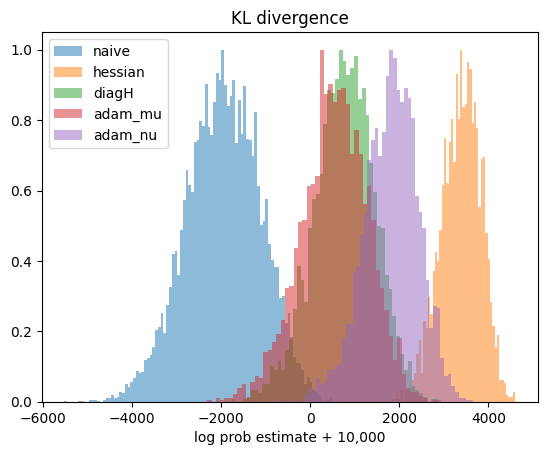

In [23]:
settings = {'alpha': 0.5, 'fill': True}
for label, results in RESULTS.items():
    # if label in ['hessian', 'adam_mu']:
    #     continue
    these_settings = dict(settings, label=label)
    scaled_histogram(results[0] + 10_000, label, these_settings)
plt.xlabel("log prob estimate + 10,000")
plt.legend()
plt.title("KL divergence")
plt.show()